In [287]:
import numpy as np
import cv2 as cv
import sys


"""Transform Rectangle Image to Square

Change the original image from rectanle to square,
so we can build RR square without out of boundary

Args:
    img: source image

Returns:
    squared image

"""
def makeSqaureImg(src):
    h,w = src.shape[0], src.shape[1]
    topPad, bottomPad, leftPad, rightPad = 0, 0, 0, 0
    if h >= w:
        rightPad = h-w
    else:
        bottomPad = w-h

    padding = [topPad, bottomPad, leftPad, rightPad]
    # add additional padding 10px for each edge, so we can see axes clearly
    padding = [x + EXTRA_PADDING for x in padding]
    sqauredImg = cv.copyMakeBorder(src, padding[0], padding[1], padding[2], padding[3], cv.BORDER_CONSTANT,value=(255,255,255))
    return sqauredImg


"""Draw Rect for testing
Args:
    copyOfsqauredImg: A copy of squared image
    limit: limit the width and height, default is 100
"""
def drawRect(copyOfsqauredImg, cnts, limit = 100):
    # draw contour rectangle
    for cnt in cnts:
        x,y,w,h = cv.boundingRect(cnt)
        if limit:
            if w > limit and h > limit:
                cv.rectangle(copyOfsqauredImg, (x,y),(x+w,y+h), (0,255,0), 2, cv.LINE_AA)

                
"""Draw RR
RR square is render N*N squares on screen depends on the size of square image and RR radius.
The original image will be separate by the white RR line.

Args:
    copyOfsqauredImg: a copy of squared image
    showDetail: True show bouding rect, RR label, blue RR line
    
"""            
def drawRR(copyOfsqauredImg, showDetail = False):
    # getStartCoordiante for Axes
    startCoordinate = findStartCoordinate(src)
    startCoordianteX, startCoordianteY  = startCoordinate[0], startCoordinate[1]
    
    # get curren positions trackbars
    RR_radius = cv.getTrackbarPos('RR_radius', 'Partition')
    RR_thickness = 4
    numberOfRRPerRow = round(maxSizeOfSrcImg/RR_radius)
    
    RR_LineColor =  (255, 0, 0) if showDetail else (255, 255, 255)
    
    RR = np.zeros((numberOfRRPerRow, numberOfRRPerRow, 4), np.uint32)
    
    for row in range(numberOfRRPerRow):
        for col in range(numberOfRRPerRow):
            # each start position
            # start point
            x1 = EXTRA_PADDING + startCoordianteX + col * RR_radius 
            y1 = EXTRA_PADDING + startCoordianteY + row * RR_radius
            # end point
            x2 = EXTRA_PADDING + startCoordianteX + (col+1) * RR_radius 
            y2 = EXTRA_PADDING + startCoordianteY + (row+1) * RR_radius
            # print(row, col, x1, y1, x2, y2)
            cv.rectangle(copyOfsqauredImg, (x1,y1), (x2, y2), RR_LineColor, RR_thickness, cv.LINE_AA)
            RR[row][col] = [x1,y1,x2,y2]
            
            if showDetail:
                # add RR label
                cv.putText(copyOfsqauredImg, 'RR'+str(row)+','+str(col), (x1,y1+30), cv.FONT_HERSHEY_SIMPLEX, 1,(255,0,0), 2, cv.LINE_AA)
     
    return RR, RR_radius

        
"""Find Start Coordinate
Get all contours' bouding rectangles and get min y and min x from rectangle.
Args:
    cnts: original contours
Returns:
    StartCoordinate tuple (minX,minY)
"""
def findStartCoordinate(src):
    cnts = findExternalContours(src)
    
    minX, minY = sys.maxsize, sys.maxsize
    for cnt in cnts:
        rect = cv.boundingRect(cnt)
        x, y = rect[0], rect[1]
        minX = min(minX, x)
        minY = min(minY, y)
    return (minX,minY)


"""Find Original Contours
Find Original Contours from source image, we only need external contour.
Args:
    src: source image
Returns:
    Original contours
"""
def findExternalContours(src):
    # preprocess, remove noise, a lot noise on the road
    gray = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
    
    thresVal = 240
    maxVal = 255
    ret,thresh1 = cv.threshold(gray, thresVal, maxVal, cv.THRESH_BINARY)
    
    kernel = np.ones((5,5),np.uint8)
    opening = cv.morphologyEx(thresh1, cv.MORPH_CLOSE, kernel)
    
    edges = cv.Canny(opening,100,200)
    contours, hierarchy = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
#     cv.imshow('gray', gray)
#     cv.imshow('thresh1', thresh1)
#     cv.imshow('opening', opening)
    return contours


"""Contour Intersect
"""
def ccw(A,B,C):
    return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])

def contour_intersect(cnt_ref,cnt_query):

    ## Contour is a list of points
    ## Connect each point to the following point to get a line
    ## If any of the lines intersect, then break

    for ref_idx in range(len(cnt_ref)-1):
    ## Create reference line_ref with point AB
        A = cnt_ref[ref_idx][0]
        B = cnt_ref[ref_idx+1][0] 
        #print('A', A, 'B', B)
    
        for query_idx in range(len(cnt_query)-1):
            ## Create query line_query with point CD
            C = cnt_query[query_idx][0]
            D = cnt_query[query_idx+1][0]
        
            ## Check if line intersect
            if ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D):
                ## If true, break loop earlier
                return True

    return False


"""Chunked contour in side RR
"""
def ccInRR(cc, rr):
    rrX1, rrY1, rrX2, rrY2 = rr[0],rr[1],rr[2],rr[3]
    for ccPtr in cc:
        ccX, ccY = ccPtr[0][0], ccPtr[0][1] 
        if ccX < rrX1 or ccX > rrX2 or ccY < rrY1 or ccY > rrY2:
            return False
    return True
    
    
"""Get the RR and Origianl contours dictionary
Get the RR region as Hot Cold Region and has a list of original contours related to the Hot Cold Region

This function is the slowest, here is the sinppet for performance test
    e1 = cv.getTickCount()
    # your code execution
    e2 = cv.getTickCount()
    time = (e2 - e1)/ cv.getTickFrequency()
    print('analysis time', time)

Performance test result:
    # intersectConvexConvex, time 0.xx , not accurate, only got 2
    # contourIntersect time 758.4623937
    # contour_intersect time 423.6874939
    # contour_intersect with approxPolyDP to reduce points, time 0.7358804

Args:
    RR: RR region, and after calculated it will be the Hot Cold Region
    originalCnts: Origianl contours
    chunkedCnts: chunked up Origianl contours
    RR_radius: RR region's size, RR is a square

Returns:
    rrocDict: RR to Origianl contours dictionary
    ocRRDict: Origianl contours to RR dictionary
"""    
def getRROCDic(RR, originalCnts, chunkedCnts, RR_radius):
    
    # prepare RR area for rrRatio = ccArea / rrArea
    rrArea = RR_radius * RR_radius
    
    # prepare chunked contour to RR's dictionary
    ccRRDict = {}
    
    for row, rrRow in enumerate(RR):
        for col, rr in enumerate(rrRow):
        
            for ccIndex, cc in enumerate(chunkedCnts):
                ccArea = cv.contourArea(cc)
                # exclude too small chunked contour and some noises point
                if ccArea < 100:
                    continue

                # Contour Approximation to reduce points and save calculation time
                epsilonCC = 0.1 * cv.arcLength(cc,True)
                approxCC = cv.approxPolyDP(cc,epsilonCC,True)

                retval = ccInRR(approxCC, rr)
                if retval:
                    rrRatio = round(ccArea/rrArea*100, 2)
                    rrIndex = row * (len(RR)) + col
                    # cc and rr are one to one relationship
                    ccRRDict[ccIndex] = [rrIndex, rrRatio]
                    
        
    # prepare original contour to RR's dictionary by the chunked contour and RR's dictionary
    ocRRDict = {}
    for ocIndex, oc in enumerate(originalCnts):
        for ccIndex, cc in enumerate(chunkedCnts):
            
            # the cc may be too small to be calculated, it may not in the ccRRDict, skip it
            if ccIndex not in ccRRDict:
                continue
            
            # Contour Approximation to reduce points and save calculation time
            epsilonOC = 0.1 * cv.arcLength(oc,True)
            approxOC = cv.approxPolyDP(oc,epsilonOC,True)
            
            epsilonCC = 0.1 * cv.arcLength(cc,True)
            approxCC = cv.approxPolyDP(cc,epsilonCC,True)
            
            retval = contour_intersect(approxOC, approxCC)
            if retval:
                rr = ccRRDict[ccIndex] 
                rrIndex = rr[0]
                rrRatio = rr[1]
                if ocIndex not in ocRRDict:
                    ocRRDict[ocIndex] = [rrIndex, rrRatio]
                else:
                    # check if the current cc's RR ratio is bigger than the previous saved in ocRRDict one
                    prevRR = ocRRDict[ocIndex]
                    prevRatio = prevRR[1]
                    if rrRatio > prevRatio:
                        ocRRDict[ocIndex] = [rrIndex, rrRatio]
                        
    # get RR to original contours map
    rrocDict = {}
    for ocIndex in ocRRDict:
        rr = ocRRDict[ocIndex]
        rrIndex = rr[0]
        ocList = rrocDict.get(rrIndex, [])
        ocList.append(ocIndex)
        rrocDict[rrIndex] = ocList
        
#     print('ccRRDict', ccRRDict)
#     print('ocRRDict', ocRRDict)
#     print('rrocDict', rrocDict)
    return rrocDict, ocRRDict
    
"""Render Image

Render image with track bars, sqaure image, RR square, axes.
Track bars:    RR_radius - size for RR squqre
Square image:  the squared source image
RR square:     render N*N squares on screen depends on the size of square image and RR radius
Axes:          line to mark where the RR square start

Args:
    x: x

Raises:
    ZeroDivisionError: division by zero

"""
def renderImage(x):
    # 1 show details of RR
    copyOfsqauredImgForDetail = sqauredImg.copy()
    # find original contours for data preparation
    originalCnts = findExternalContours(copyOfsqauredImgForDetail)
    
    # draw RR for testing
    RR, RR_radius = drawRR(copyOfsqauredImgForDetail, True)
    
    # 2 start collecting HotCold Region
    copyOfsqauredImgForHC = sqauredImg.copy()
    # draw RR
    drawRR(copyOfsqauredImgForHC)
    # find chunked contours
    chunkedCnts = findExternalContours(copyOfsqauredImgForHC)
    
    # add chunked contour ID for testing
    for ccIndex, cc in enumerate(chunkedCnts):
        x,y,w,h = cv.boundingRect(cc)
        cv.putText(copyOfsqauredImgForHC, str(ccIndex), (x+5,y+10), cv.FONT_HERSHEY_PLAIN, 1,(255,0,0), 1, cv.LINE_AA)
    cv.imshow('copyOfsqauredImgForHC with CCID', copyOfsqauredImgForHC)
    
    # get dictionary for RR and origianl contour's relationship
    rrocDict, ocRRDict = getRROCDic(RR, originalCnts, chunkedCnts, RR_radius)
    
    # mark HOT COLD regison with different colors, same hot cold region use the same color
    for rrIndex in rrocDict:
        # prepare color for the same hot cold region's contours
        b = 250 - rrIndex * 4
        g = 250 - rrIndex * 4
        r = 250 - rrIndex * 4
        color = (b, g, r)
        for ocIndex in rrocDict[rrIndex]:
            cv.fillConvexPoly(copyOfsqauredImgForHC, originalCnts[ocIndex], color)
    
    # mark missed original contour as black for us to fix them later
    # not sure why, but the intersection algorithm is most likely to be the root cause
    for ocIndex, oc in enumerate(originalCnts):
        if ocIndex not in ocRRDict:
            cv.fillConvexPoly(copyOfsqauredImgForHC, oc, (0,0,0))
            
#     print(len(originalCnts))
#     cv.drawContours(copyOfsqauredImgForDetail, originalCnts, -1, (0,0,255), 2)
#     drawRect(copyOfsqauredImgForDetail, originalCnts)    
#     print(len(chunkedCnts))
#     cv.drawContours(copyOfsqauredImgForHC, chunkedCnts, -1, (0,0,255), 2)
#     drawRect(copyOfsqauredImgForHC, chunkedCnts, False)

    cv.imshow('Partition', copyOfsqauredImgForDetail)
    cv.imshow('CopyOfsqauredImgForHC', copyOfsqauredImgForHC)
    


# init
# init global constant
EXTRA_PADDING = 10
# init global variables here
src = cv.imread('partition1.png')

# resize to half
src = cv.resize(src, (0,0), fx=0.3, fy=0.3) 

# prepare size and sqaured image after resize for a better demo
maxSizeOfSrcImg = max(src.shape[0], src.shape[1])
sqauredImg = makeSqaureImg(src)

    
# prepare     
# create a widnow
cv.namedWindow('Partition')
# cteate trackbars RR radius changes
# RR radius for draw rectangle, 220 is as the demo
cv.createTrackbar('RR_radius', 'Partition', 220, maxSizeOfSrcImg, renderImage)

# render 
renderImage(-1)

# loop until use press ESC
while(1):
    k = cv.waitKey(100) & 0xFF
    if k == 27:
        break
    
cv.destroyAllWindows()     

In [266]:
for index, i in enumerate([22,33,44]):
    print(index, i)

0 22
1 33
2 44


[array([[[0, 0]],

       [[0, 2]],

       [[2, 2]],

       [[2, 0]]], dtype=int32)]
[[[0 0]]

 [[0 2]]

 [[2 2]]

 [[2 0]]] (4, 1, 2)
[[[0, 0]], [[0, 2]], [[2, 2]], [[2, 0]]]
[[[0 0]]

 [[0 2]]

 [[2 2]]

 [[2 0]]] (4, 1, 2)
1.0


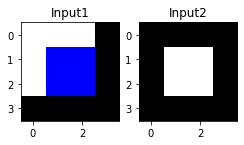

In [186]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

_p1 = np.zeros((4,4,3), np.uint8)
_p1[0:3, 0:3] = [255,255,255]
gray_p1 = cv.cvtColor(_p1, cv.COLOR_BGR2GRAY)
cnts1 = cv.findContours(gray_p1, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)[0]
print(cnts1)
for oc in cnts1:
    epsilonOC = 0.1 * cv.arcLength(oc,True)
#     approxOC = np.array(cv.approxPolyDP(oc,epsilonOC,True), np.int32)
    approxOC = cv.approxPolyDP(oc,epsilonOC,True)
    print(approxOC, approxOC.shape)
    cvtPtsOC = []
    for pt in approxOC:
        cvtPtsOC.append([[pt[0][0], pt[0][1]]])
        
    print(cvtPtsOC)
    cvtPtsOC = np.array(cvtPtsOC, np.int32)
    print(cvtPtsOC, cvtPtsOC.shape)

_p2 = np.zeros((4,4,3), np.uint8)
_p2[1:3, 1:3] = [255,255,255]
gray_p2 = cv.cvtColor(_p2, cv.COLOR_BGR2GRAY)
cnts2 = cv.findContours(gray_p2, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)[0]

retval, _p12 = cv.intersectConvexConvex(cnts1[0], cnts2[0])
cv.drawContours(_p1, np.array(_p12, np.int32), -1, (255,0,0))
print(retval)
# print(_p1)
# print(cnts1)
# print(_p2)
# print(_p12)

_p1 = _p1[:,:,::-1]
# print(_p1)
plt.subplot(131),plt.imshow(_p1),plt.title('Input1')
plt.subplot(132),plt.imshow(_p2),plt.title('Input2')
plt.show()


In [173]:
test = np.array([[1,2,3],[4,5,6]], np.int32)
test[:,::-1]

70/100

0.7

[[1 1]
 [1 2]
 [2 1]
 [2 2]]
1.0


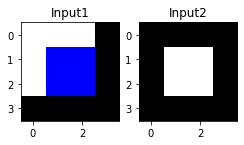

In [94]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

_p1 = np.zeros((4,4,3), np.uint8)
_p1[0:3, 0:3] = [255,255,255]
gray_p1 = cv.cvtColor(_p1, cv.COLOR_BGR2GRAY)
cnts1 = cv.findContours(gray_p1, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)[0]

_p2 = np.zeros((4,4,3), np.uint8)
_p2[1:3, 1:3] = [255,255,255]
gray_p2 = cv.cvtColor(_p2, cv.COLOR_BGR2GRAY)
cnts2 = cv.findContours(gray_p2, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)[0]


# pixelpoints = np.transpose(np.nonzero(gray_p2))
# pixelpoints = cv.findNonZero(gray_p2)
print(pixelpoints)

retval, _p12 = cv.intersectConvexConvex(cnts1[0], cnts2[0])
cv.drawContours(_p1, np.array(_p12, np.int32), -1, (255,0,0))
print(retval)
# print(_p1)
# print(cnts1)
# print(_p2)
# print(_p12)

_p1 = _p1[:,:,::-1]
# print(_p1)
plt.subplot(131),plt.imshow(_p1),plt.title('Input1')
plt.subplot(132),plt.imshow(_p2),plt.title('Input2')
plt.show()


# Mask and Pixel Points
# we may use this to check if the chunked contour is in the original contour by mask or points comparison
# mask = np.zeros(imgray.shape,np.uint8)
# cv.drawContours(mask,[cnt],0,255,-1)
# pixelpoints = np.transpose(np.nonzero(mask))
#pixelpoints = cv.findNonZero(mask)

In [164]:
1.0 == 1

True

In [ ]:
def contour_intersect(cnt_ref, cnt_query, edges_only = True):
    
    intersecting_pts = []
    
    ## Loop through all points in the contour
    for pt in cnt_query:
        x,y = pt[0]

        ## find point that intersect the ref contour
        ## edges_only flag check if the intersection to detect is only at the edges of the contour
        
        if edges_only and (cv.pointPolygonTest(cnt_ref,(x,y),True) == 0):
            intersecting_pts.append(pt[0])
        elif not(edges_only) and (cv.pointPolygonTest(cnt_ref,(x,y),True) >= 0):
            intersecting_pts.append(pt[0])
            
    if len(intersecting_pts) > 0:
        return True
    else:
        return False

In [ ]:
def ccw(A,B,C):
    return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])

def contour_intersect(cnt_ref,cnt_query):

    ## Contour is a list of points
    ## Connect each point to the following point to get a line
    ## If any of the lines intersect, then break

    for ref_idx in range(len(cnt_ref)-1):
    ## Create reference line_ref with point AB
        A = cnt_ref[ref_idx][0]
        B = cnt_ref[ref_idx+1][0] 
    
        for query_idx in range(len(cnt_query)-1):
            ## Create query line_query with point CD
            C = cnt_query[query_idx][0]
            D = cnt_query[query_idx+1][0]
        
            ## Check if line intersect
            if ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D):
                ## If true, break loop earlier
                return True

    return False

In [ ]:
def contourIntersect(original_image, contour1, contour2):
    # Two separate contours trying to check intersection on
    contours = [contour1, contour2]

    # Create image filled with zeros the same size of original image
    blank = np.zeros(original_image.shape[0:2])

    # Copy each contour into its own image and fill it with '1'
    image1 = cv.drawContours(blank.copy(), contours, 0, 1)
    image2 = cv.drawContours(blank.copy(), contours, 1, 1)

    # Use the logical AND operation on the two images
    # Since the two images had bitwise AND applied to it,
    # there should be a '1' or 'True' where there was intersection
    # and a '0' or 'False' where it didnt intersect
    intersection = np.logical_and(image1, image2)

    # Check if there was a '1' in the intersection array
    return intersection.any()

In [ ]:
#Calculate the intersection of the contour and the circle, and return the coordinates of the intersection.
def get_contour_circle_intersection(contour,circle):
    '''
         Calculate the intersection of the contour and the circle, and return the coordinates of the intersection.
         contour: contour
         circil: single-channel grayscale image
    '''
         mask = np.zeros(circle.shape, np.uint8) # Generate a mask with the same structure as circle
         cv2.drawContours(mask, [contour], -1, 255, 1) #Draw the contour
         dst=cv2.bitwise_and(mask,circle) #and operation of contour and circle
         dst=cv2.dilate(dst, None) #point obtained by expansion
         res=get_corner(dst) #Get the corner coordinates of the point
    return res
 
 
def get_corner(grayimg):
    """Corner Test Demo
                 grayimg: is a grayscale image
                 Return res
                         Corner coordinates, 1, 2 are sub-pixel corners, 3, 4 are corners
    """
    gray = np.float32(grayimg)
    cornerP = cv2.cornerHarris(gray, 3, 5, 0.04)
    cornerP[cornerP > 0] = 255
 
 
         #cornerP=cv2.dilate(cornerP,None) #dilate
         ret, cornerP = cv2.threshold(cornerP, 0.01 * cornerP.max(), 255, 0) #threshold binarization
    cornerP = np.uint8(cornerP)
    cv2.imshow('cornerP', cornerP)
         # Image connected domain
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(cornerP) #？？？？？？？？？？
         # Iteration stop rule
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
         corners = cv2.cornerSubPix(gray, np.float32(centroids), (5, 5), (-1, -1), criteria) #Calculate sub-pixel corner points
         res = np.hstack((centroids[1:], corners[1:])) #list is tiled horizontally
         res = np.int0(res) #list rounding
    return res